In [ ]:
#%pip install torch torchvision torchaudio
#%pip install scipy
#%pip install torch
#%pip install pyinform

import pandas as pd
import numpy as np
from binance.client import Client
import kagglehub
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
import yfinance as yf
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm

c:\Users\Mert\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Mert\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [1]:
from utils.calibration import *

ModuleNotFoundError: No module named 'utils'

Downloading Elon Musk Tweets

In [ ]:
# Download latest version
path = kagglehub.dataset_download("gpreda/elon-musk-tweets")
print("Path to dataset files:", path)

In [4]:
"""
API Key
Hv6Q2xCqZ1h7mm6v25GrfwBieM4VMxFAQ9h2G8ojZB4SnX6HMQN0dzOWXzIwJxMg
Secret Key
xTNQ1iICNI2Xu8h5YS8GYSiL7BDd4GQSWtdvIXnZzffsdhUnlmFKWrDDaFSaIwUf
"""

'\nAPI Key\nHv6Q2xCqZ1h7mm6v25GrfwBieM4VMxFAQ9h2G8ojZB4SnX6HMQN0dzOWXzIwJxMg\nSecret Key\nxTNQ1iICNI2Xu8h5YS8GYSiL7BDd4GQSWtdvIXnZzffsdhUnlmFKWrDDaFSaIwUf\n'

In [136]:
#Helper function to read the desired file
def read_file(file_path):

    file_extension = file_path.split('.')[-1].lower()

    try:
        if file_extension == 'csv':
            # Read CSV file
            df = pd.read_csv(file_path)
            if "date" in df.columns:
                df["date"] = df["date"].apply(lambda val: pd.to_datetime(val))
            elif "Date" in df.columns:
                df["Date"] = df["Date"].apply(lambda val: pd.to_datetime(val))
        elif file_extension == 'parquet':
            # Read Parquet file
            df = pd.read_parquet(file_path)
            if "date" in df.columns:
                df["date"] = df["date"].apply(lambda val: pd.to_datetime(val))
            elif "Date" in df.columns:
                df["Date"] = df["Date"].apply(lambda val: pd.to_datetime(val))
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
    except Exception as e:
        raise ValueError(f"Error reading file: {e}")

    return df


In [135]:
#Helper function to write the desired file
def write_file(df, file_path):

    file_extension = file_path.split('.')[-1].lower()

    try:
        if file_extension == 'csv':
            # Write to CSV
            df.to_csv(file_path, index=False)
        elif file_extension == 'parquet':
            # Write to Parquet
            df.to_parquet(file_path, engine="pyarrow", index=False)
        else:
            raise ValueError(f"Unsupported file type: {file_extension}")
    except Exception as e:
        raise ValueError(f"Error writing file: {e}")


In [5]:
#Pipeline generator function
def optimization_pipeline(df, transformations):
    for func, kwargs in transformations:
        df = func(df, **kwargs)
    return df

In [137]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# We will use distilRoberta-financial-sentiment a fine-tuned version of distilroberta-base on the financial_phrasebank dataset
def distill_roberta_classify_sentiment(article):
    sentiment_result = sentiment_pipeline(article)[0]
    label = sentiment_result['label']
    
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:
        return 0


Get the TSLA news data

In [141]:
tsla_news = read_file("../data/raw/TSLA_news.parquet")
tsla_news.head()

,Date,Stock_symbol,Article_title
0,2023-12-16 22:00:00,TSLA,Scotiabank's Mexico bet eyeing $1.6 trillion N...
1,2023-12-16 20:00:00,TSLA,Can the 'Magnificent Seven' Continue to Lead t...
2,2023-12-16 20:00:00,TSLA,"Notable ETF Outflow Detected - IWB, TSLA, LLY,..."
3,2023-12-16 20:00:00,TSLA,"Swedes support Tesla mechanics' strike, poll s..."
4,2023-12-16 20:00:00,TSLA,"Some Potential 2024 Winners Reside in QQQ, QQQM"


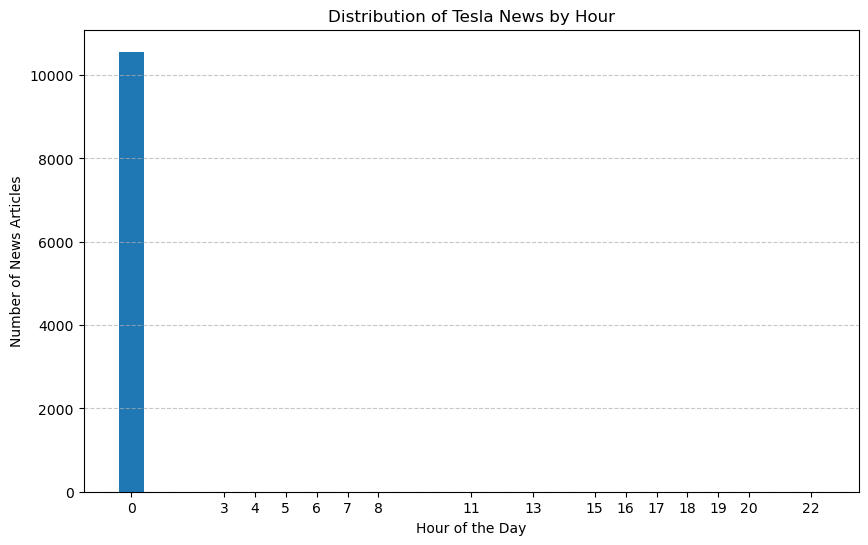

In [142]:
# Assuming `tsla_news` is your DataFrame and `Date` is a datetime column
# Extract the hour from the Date column
hour_counts = pd.DataFrame(tsla_news["Date"].apply(lambda val: val.hour)).value_counts().sort_index()

# Convert the result into a proper DataFrame
hour_counts = hour_counts.reset_index()
hour_counts.columns = ['Hour', 'Count']

# Sort the DataFrame by Hour
hour_counts = hour_counts.sort_values(by='Hour')

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(hour_counts['Hour'], hour_counts['Count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Number of News Articles')
plt.title('Distribution of Tesla News by Hour')
plt.xticks(hour_counts['Hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [143]:
#Sentiment Analysis on Tesla Stock"
tqdm.pandas()
tsla_news['Sentiment'] = tsla_news['Article_title'].progress_apply(distill_roberta_classify_sentiment)

100%|██████████| 10587/10587 [04:54<00:00, 35.97it/s]


In [144]:
#Preprocess and write the file
tsla_news = tsla_news.rename({"Date":"date","Article_title":"text"}, axis = 1).filter(["date","text","Sentiment"])
tsla_news["date"] = tsla_news["date"].apply(lambda val: pd.to_datetime(val))

#Writing the file
write_file(tsla_news,"../data/clean/tsla_news_with_sent.csv")

Get the Tesla Quotes

In [38]:
def get_tesla_stock_data(start_date: str, end_date: str = None) -> pd.DataFrame:

    # Define the ticker symbol for Tesla
    ticker_symbol = "TSLA"

    # Fetch data using yfinance
    tesla_data = yf.download(ticker_symbol, start=start_date, end=end_date)

    # Ensure the Date column is part of the DataFrame
    tesla_data.reset_index(inplace=True)

    return tesla_data

# Example usage
start_date = "2019-07-01"
end_date = "2023-12-31"
tesla_stock_data = get_tesla_stock_data(start_date, end_date)

# Display the data
tesla_stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-01,15.347333,15.540000,15.085333,15.144667,15.144667,123201000
1,2019-07-02,15.259333,15.276667,14.814667,14.970000,14.970000,138885000
2,2019-07-03,15.959333,16.104668,15.634000,15.660000,15.660000,213016500
3,2019-07-05,15.638000,15.696667,15.386667,15.540000,15.540000,105985500
4,2019-07-08,15.416000,15.483333,15.244000,15.356000,15.356000,88207500


In [39]:
#Preprocess and writing the Tesla Quotes
tesla_stock_data = tesla_stock_data.filter(["Date","Close"])
tesla_stock_data["Date"] = tesla_stock_data["Date"].apply(lambda val:pd.to_datetime(val))

#Writing the file
write_file(tesla_stock_data,"../data/clean/tesla_quotes.csv")

Get the Elon Musk Tweets

In [30]:
tweet_df = read_file("../data/raw/elon_musk_tweets.csv")
tweet_df = tweet_df.filter(["date", "text"])
tweet_df.head()

,date,text
0,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...
1,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks"
2,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...
3,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it
4,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...


Sentiment Analysis for Elon's tweets

In [47]:
tqdm.pandas()
tweet_df['Sentiment'] = tweet_df['text'].progress_apply(distill_roberta_classify_sentiment)


100%|██████████| 5904/5904 [03:08<00:00, 31.28it/s]


Sentiment Scores for Elon Tweets

In [49]:
tweet_df = read_file("../data/processed/elon_tweet_sentiment.csv")

# Convert 'date' column to datetime format
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

# Sort DataFrame by datetime
tweet_df = tweet_df.sort_values(by='date', ascending=True).reset_index(drop=True)

tweet_df.head()

,date,text,Sentiment
0,2022-07-05 13:46:20+00:00,@historydefined While bleak posts maybe genera...,1
1,2022-07-05 14:00:21+00:00,@TonyadeVitti @historydefined His success was ...,1
2,2022-07-05 14:42:21+00:00,@slashdot It’s time,0
3,2022-07-05 17:36:03+00:00,I must confess to a penchant for creative socks,0
4,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,0


In [85]:
write_file(tweet_df,"../data/clean/musk_tweets_with_sent.csv")

Getting the dogecoin price data

In [87]:
def fetch_doge_minute_data_from_binance(
    api_key: str = None,
    api_secret: str = None,
    start_date: str = "1 Jan, 2023",
    end_date: str = None
) -> pd.DataFrame:
    """
    Fetch minute-level historical OHLCV data for DOGE/USDT from Binance.
    Supports large date ranges by chunking requests.
    """
    # Create Binance client
    client = Client(api_key, api_secret)
    
    # Symbol and interval
    symbol = "DOGEUSDT"
    interval = "1m"  # Use the string literal for 1-minute interval
    
    # Convert start and end dates to datetime
    start_datetime = pd.to_datetime(start_date)
    end_datetime = pd.to_datetime(end_date) if end_date else datetime.utcnow()
    
    # Initialize an empty DataFrame to store results
    all_data = []
    
    # Fetch data in chunks (max 1,000 candles per request)
    while start_datetime < end_datetime:
        # Define the end of the current chunk
        chunk_end = start_datetime + timedelta(minutes=1000)
        if chunk_end > end_datetime:
            chunk_end = end_datetime
        
        # Fetch data for the current chunk
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=interval,
            start_str=start_datetime.strftime("%d %b, %Y %H:%M:%S"),
            end_str=chunk_end.strftime("%d %b, %Y %H:%M:%S")
        )
        
        # Append to the all_data list
        all_data.extend(klines)
        
        # Move the start_datetime forward
        start_datetime = chunk_end
    
    # Convert the collected data to a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume", 
        "Close Time", "Ignore1", "Ignore2", "Ignore3", "Ignore4", "Ignore5"
    ])
    
    # Keep only the important columns
    df = df[["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time"]]
    
    # Convert time columns from milliseconds to datetime
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit='ms', utc=True)
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit='ms', utc=True)
    
    # Convert numeric columns
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Rename for clarity
    df.rename(columns={
        "Open Time": "time_open",
        "Close Time": "time_close"
    }, inplace=True)
    
    return df

# Example usage
df_doge = fetch_doge_minute_data_from_binance(
    api_key="Hv6Q2xCqZ1h7mm6v25GrfwBieM4VMxFAQ9h2G8ojZB4SnX6HMQN0dzOWXzIwJxMg",
    api_secret="xTNQ1iICNI2Xu8h5YS8GYSiL7BDd4GQSWtdvIXnZzffsdhUnlmFKWrDDaFSaIwUf",
    start_date="4 Nov, 2021", #cutoff value for the TSLA stock
    end_date="16 Dec, 2023"
)


In [88]:
#Preprocess the Dogecoin price data
df_doge = (
            df_doge.filter(["time_open", "Close"])
                  .rename({"time_open":"Date"}, axis = 1)
                  )

df_doge["Date"] = df_doge["Date"].apply(lambda val: pd.to_datetime(val))
df_doge.head()

,Date,Close
0,2021-11-04 00:00:00+00:00,0.2691
1,2021-11-04 00:01:00+00:00,0.2698
2,2021-11-04 00:02:00+00:00,0.2699
3,2021-11-04 00:03:00+00:00,0.2695
4,2021-11-04 00:04:00+00:00,0.2693


In [89]:
#Write the cleaned dataset
write_file(df_doge, "../data/clean/doge_price.parquet")

Get the crypto market news data

In [80]:
crypto_market_news_df = read_file("../data/raw/crypto_news.csv")
#First we get the date and the text and then we filter the subject as "altcoin" as Dogecoin is an altcoin
filtered_news_df = crypto_market_news_df[crypto_market_news_df["subject"] == "altcoin"].filter(["date","text"])
filtered_news_df.head()

,date,text
0,2023-12-19 06:40:41,Grayscale CEO Michael Sonnenshein believes the...
10,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p..."
13,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...
14,2023-12-18 21:47:07,Here is our weekly collection of digital asset...
16,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...


In [91]:
tqdm.pandas()
filtered_news_df['Sentiment'] = filtered_news_df['text'].progress_apply(distill_roberta_classify_sentiment)

100%|██████████| 9278/9278 [06:06<00:00, 25.32it/s]


In [ ]:
#Preprocessing the crypto news data
filtered_news_df["date"] = filtered_news_df["date"].apply(lambda val: pd.to_datetime(val))

#Writing the file
write_file(filtered_news_df, "../data/clean/crypto_news_with_sent.csv")

Merging the dataframes

In [119]:
filtered_news_df.head(), filtered_news_df.shape

(                  date                                               text  \
 0  2023-12-19 06:40:41  Grayscale CEO Michael Sonnenshein believes the...   
 10 2023-12-18 23:48:19  The new CEO, Josh Swihart, has been the vice p...   
 13 2023-12-18 22:48:00  Tether asserts to have effectively immobilized...   
 14 2023-12-18 21:47:07  Here is our weekly collection of digital asset...   
 16 2023-12-18 20:56:00  BEEG's adoption skyrockets as 37% is minted wi...   
 
     Sentiment  
 0           0  
 10          0  
 13          0  
 14          0  
 16          1  ,
 (9278, 3))

In [120]:
tweet_df.head(),tweet_df.shape

(                 date                                               text  \
 0 2022-07-05 13:46:20  @historydefined While bleak posts maybe genera...   
 1 2022-07-05 14:00:21  @TonyadeVitti @historydefined His success was ...   
 2 2022-07-05 14:42:21                                @slashdot It’s time   
 3 2022-07-05 17:36:03    I must confess to a penchant for creative socks   
 4 2022-07-05 17:38:23  Sock tech is so advanced that you can get pret...   
 
    Sentiment  
 0          1  
 1          1  
 2          0  
 3          0  
 4          0  ,
 (5904, 3))

In [149]:
tsla_news.head(),tsla_news.shape

(                 date                                               text  \
 0 2023-12-16 22:00:00  Scotiabank's Mexico bet eyeing $1.6 trillion N...   
 1 2023-12-16 20:00:00  Can the 'Magnificent Seven' Continue to Lead t...   
 2 2023-12-16 20:00:00  Notable ETF Outflow Detected - IWB, TSLA, LLY,...   
 3 2023-12-16 20:00:00  Swedes support Tesla mechanics' strike, poll s...   
 4 2023-12-16 20:00:00    Some Potential 2024 Winners Reside in QQQ, QQQM   
 
    Sentiment      Source  
 0          0  Tesla_News  
 1          1  Tesla_News  
 2         -1  Tesla_News  
 3          1  Tesla_News  
 4          0  Tesla_News  ,
 (10587, 4))

In [151]:
# Convert 'date' columns to datetime format
filtered_news_df['date'] = pd.to_datetime(filtered_news_df['date'])
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

# Remove timezone information (if any)
filtered_news_df['date'] = filtered_news_df['date'].dt.tz_localize(None)
tweet_df['date'] = tweet_df['date'].dt.tz_localize(None)

# Merge the DataFrames with an indicator
merged_df = pd.concat(
    [filtered_news_df, tweet_df],
    keys=['Crypto_News', 'Tweet'],  # Add keys to identify the source
    names=['Source', 'Index']  # Name the multi-index levels
).reset_index(level=0)  # Move the 'Source' level to a column

# Sort by date
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)

# Add a 'Source' column to tsla_news
tsla_news['Source'] = 'Tesla_News'

# Convert 'date' column to datetime
tsla_news['date'] = pd.to_datetime(tsla_news['date'])

# Merge the DataFrames
combined_df = pd.concat([merged_df, tsla_news], ignore_index=True)

# Sort by date
combined_df = combined_df.sort_values(by='date').reset_index(drop=True)

combined_df

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


In [152]:
#Writing to processed
write_file(combined_df, "../data/processed/final_df.csv")

### 1. News-data Preprocessing

**Here we start our data processing work to convert get the sentiment**

Assume that the dataset of the news is a constant flow of the news, then we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Note that the news are always released in two ways: one is that the news are released at **midnight(or non-trading time) in batches**, the others are released during **trading time without batches(flow-released news)**. For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the stock $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from stock to stock. Think of it as some sort of jump process.

Extract the merged market news data to start our main analysis

In [123]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


# **First Analysis**: TESLA NEWS ON TESLA PRICE

In [169]:
#Tesla price data
tsla_price = read_file("../data/clean/tesla_quotes.csv")
tsla_price.head()

,Date,Close
0,2019-07-01,15.144667
1,2019-07-02,14.970000
2,2019-07-03,15.660000
3,2019-07-05,15.540000
4,2019-07-08,15.356000


Calulate the log-retuns for Tesla

In [198]:
# Calculate log returns
def calculate_log_returns(data, delta = 1, column_name='Close'):
    data.rename({"Date":"date"}, axis = 1, inplace = True)
    data['Log_Return'] = np.log(data[column_name] / data[column_name].shift(delta))
    data = data.dropna() 
    return data

In [171]:
#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(tsla_price)
returns_data.head()

,date,Close,Log_Return
1,2019-07-02,14.970000,-0.011600
2,2019-07-03,15.660000,0.045061
3,2019-07-05,15.540000,-0.007692
4,2019-07-08,15.356000,-0.011911
5,2019-07-09,15.337333,-0.001216


### 2. Return-data preprocessing

#### Now that we have our data set with the sentiments, we want to link it to our stock price

Discretize the tick-by-tick data to align with the news-data, by identifying the return of the price. When the batch news are released in non-trading time, assume that the traders in the market will react to the news as soon as the trading time starts, for flow-released news, assume that the market participants will react as soon as the information of the news is understood. There will be **one hyperparameter**:
  - The time-lag between the new release and the market reaction: $\gamma$

Set the return of the stock as positive, stable and negative under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock return.

The formula for the stochastic process of the discretized return can be written as 

$$
R_{t}^{s} = h(\log \frac{P_{t + 1}^{s}}{P_{t}^{s}}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

 - $P_{t}^{s}$ is the price of stock $s$ at time $t$
 - $(\log \frac{P_{t + 1}^{s}}{P_{t}^{s}})$ is the daily log-return


In [172]:
def classify_returns(df, column_name, gamma):
    
    def classify_return(x):
        if x > gamma:
            return 1  # Positive return
        elif x < -gamma:
            return -1  # Negative return
        else:
            return 0  # Stable return
    
    df['Return_Label'] = df[column_name].apply(classify_return)
    return df

 - News published after 4 PM is assigned to the next trading day

 - Sentiment data is aggregated by trading day using the mean

 - Left join with returns_data to retain only rows with both sentiment and return data

In [199]:
def process_and_merge_data(df, sentiment_data):
    """
    Process sentiment data and merge it with returns data.
    """
    # Create a copy of sentiment_data to avoid SettingWithCopyWarning
    sentiment_data = sentiment_data.copy()

    # 1. Process sentiment data and assign news published after 4 PM to the next trading day
    # Convert 'date' column to datetime with the correct format
    sentiment_data.loc[:, 'date'] = pd.to_datetime(sentiment_data['date'], format='%Y-%m-%d %H:%M:%S')
    
    # Assign news published after 4 PM to the next trading day
    sentiment_data.loc[:, 'Trading_date'] = sentiment_data['date'].apply(
        lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
    )

    # 2. Process returns data
    # Convert 'date' column to datetime and extract the date part
    df = df.copy()  # Create a copy of df to avoid SettingWithCopyWarning
    df.loc[:, 'date'] = pd.to_datetime(df['date']).dt.date

    # 3. Create daily sentiment averages because the return data is daily
    daily_sentiment = sentiment_data.groupby('Trading_date')['Sentiment'].mean().reset_index()

    # Ensure 'Trading_date' in daily_sentiment is of type datetime64[ns] or date
    daily_sentiment['Trading_date'] = pd.to_datetime(daily_sentiment['Trading_date']).dt.date

    # 4. Merge sentiment with returns data
    # Ensure both 'date' and 'Trading_date' are of the same type (datetime64[ns] or date)
    df['date'] = pd.to_datetime(df['date']).dt.date
    daily_sentiment['Trading_date'] = pd.to_datetime(daily_sentiment['Trading_date']).dt.date

    merged_data = pd.merge(
        df,
        daily_sentiment,
        left_on='date',
        right_on='Trading_date',
        how='inner'
    )

    return merged_data

In [201]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Tesla_News"]

intermediate_data = process_and_merge_data(returns_data,sentiment_data)


intermediate_data['date'] = pd.to_datetime(intermediate_data['date'])

#Cutoff value for Tesla
intermediate_data = intermediate_data[intermediate_data['date'] >= pd.Timestamp('2022-05-02')].reset_index(drop = True)


intermediate_data.head()

,date,Close,Log_Return,Trading_date,Sentiment
0,2022-05-02,300.980011,0.036290,2022-05-02,0.176471
1,2022-05-03,303.083344,0.006964,2022-05-03,0.320000
2,2022-05-04,317.540009,0.046596,2022-05-04,-0.285714
3,2022-05-05,291.093323,-0.086960,2022-05-05,-0.333333
4,2022-05-06,288.549988,-0.008776,2022-05-06,-0.105263


In [202]:
write_file(intermediate_data,"../data/processed/input_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

### 3.Get transfer entropy

After we construct on the two stochastic processes $I_{t}^{s}$ and $R_{t}^{s}$, calculate the transfer entropy of the two random processes

Before we move on, we **discretize** the sentiment scores to get into the value range (-1,0,1) as we took the average when converting them into daily scores. Therefore, we are going to have an additional parameter when classifying:

$$
I_t^s =
\begin{cases} 
1, & I_t^s > \beta \quad (\text{Positive sentiment}) \\\
0, & -\beta \leq I_t^s \leq \beta \quad (\text{Neutral sentiment}) \\\
-1, & I_t^s < -\beta \quad (\text{Negative sentiment})
\end{cases}
$$

The transfer entropy is revised to be a **lagged-$\Delta$ conditional/local transfer entropy**, which $\Delta$ is the lagged time for the market participants to react on the news release, and $\lambda$ is the fixed time window on the local/conditional entropy.

$$
TE(I_{t}^{s}, R_{t+\Delta}^{s} | t - \lambda : t)
$$

Mapping the states (-1,0,1) so that there are no negative-valued states don't change the result of the transfer entropy **(detail this part)**

In [203]:
#Rediscretize the sentiment scores to calculate the TE
def discretize_sentiment_column(df, beta):
    # Apply discretization logic
    df['Sentiment_Discretized'] = np.where(
        df['Sentiment'] > beta, 1,  # Positive sentiment
        np.where(df['Sentiment'] < -beta, -1, 0)  # Negative or neutral sentiment
    )
    return df


In [204]:
def calculate_and_add_transfer_entropy(df, source_col, target_col, window_size, delta):
    """
    Calculate rolling Transfer Entropy (TE) between source_col and target_col.
    """
    # Remap states (function technicality regarding pyinform.transfer_entropy)
    state_mapping = {-1: 0, 0: 1, 1: 2}
    df[source_col] = df[source_col].map(state_mapping)
    df[target_col] = df[target_col].map(state_mapping)
    
    te_values = []
    
    # Rolling TE
    for i in range(len(df) - window_size - delta + 1):
        # Source window: sentiment from t to t + window_size
        source_window = df[source_col].iloc[i : i + window_size].values
        # Target window: log returns from t + delta to t + window_size + delta
        target_window = df[target_col].iloc[i + delta : i + window_size + delta].values
        
        # Calculate TE if there are no missing values
        if not pd.isnull(source_window).any() and not pd.isnull(target_window).any():
            te = transfer_entropy(source_window, target_window, k=1)  # Use smaller k because k is the lag defined in the transfer entropy function
            te_values.append(te)
        else:
            te_values.append(None)
    
    # Pad with leading None values to align with the original DataFrame
    needed_leading_nones = window_size + delta - 1
    df['Rolling_TE'] = pd.Series([None] * needed_leading_nones + te_values, index=df.index)
    
    return df

### 4. Design trading strategy

Based on the sentiment process $I_{s}^{t}$ and the transfer entropy $TE(I_{t}^{s}, R_{t+\Delta}^{s} | t - \lambda : t)$ , design a statistic arbitrage trading strategy **(only one idea)** as follows:

````python
if (sentiment_score > 0) & (TE>threshold):
    buy stock at time t
    sell stock at time t + delta
elif (sentiment_score < 0) & (TE>threshold):
    short sell stock at time t
    buy back stock at time t + delta
else:
    continue
````

The ``threshold`` can be written as $\alpha$ for further demonstration.

The strategy can be also revised to be a long-short strategy.

In [205]:
# Define the trading strategy function
def apply_trading_strategy(df, alpha, delta):
    # For the optimization pipeline to work (prevent index breaking)
    df = df.reset_index(drop=True)
    df['Strategy_Return'] = 0.0  # Initialize column for strategy returns as float
    
    for t in range(len(df) - delta):
        sentiment_score = df.loc[t, 'Sentiment']
        te = df.loc[t, 'Rolling_TE']
        
        # Check trading conditions
        if pd.notnull(te) and (sentiment_score > 0) and (te > alpha):
            df.loc[t + delta, 'Strategy_Return'] = df.loc[t + delta, 'Log_Return']
        elif pd.notnull(te) and (sentiment_score < 0) and (te > alpha):
            df.loc[t + delta, 'Strategy_Return'] = -df.loc[t + delta, 'Log_Return']
    
    # Calculate cumulative return
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
    
    return df

### 5. Calibration and train-validation-test split

Based on the arbitrage strategy, we have several hyperparameters to be calibrated: $\delta, \gamma, \Delta, \lambda, \alpha$. The hyperparameters should be calibrated using the in-sample training set and validation set, and perform stimulation trading on the out-of-sample test set. The size of the whole train-validation-test set should be fixed and moved along the time with the moving interval to be the exact size of the test set, only using the most recent data and construct a trading performance over the whole dataframe.

Within one single train-validation-test set, the best hyperparameters for each stock $s$ are found based on the Sharpe ratio of the strategy in the **validation set**. The way of finding the best hyperparameters should be done by grid search.

**Important**: When calibrating the model use **memoisation** techniques to notice the time-difference

In [208]:
def calculate_sharpe_ratio(df, return_column='Strategy_Return'):
    """
    Calculates the Sharpe ratio for the strategy returns in `return_column`.
    """
    returns = df[return_column]
    mean_return = returns.mean()
    std_dev = returns.std()
    if std_dev == 0:
        return 0
    return mean_return / std_dev


In [303]:
def optimize_params_func(train_set, val_set, initial_params, transformations):
    """
    Example grid search to find best hyperparameters for the strategy,
    picking those that maximize the Sharpe ratio on the validation set.
    Uses Joblib for multithread processing.

    Returns:
      best_params (dict)
      best_val_sharpe (float)
    """
    # Define your search space:
    gamma_values = [0.005, 0.01, 0.015]
    beta_values = [0.3, 0.5, 0.7]
    delta_values = [1, 2, 5]
    lambda_values = [5, 10, 15]
    alpha_values = [0.1, 0.2, 0.5]
    
    # Function to evaluate a single combination of parameters
    def evaluate_params(gamma, beta, delta_, lambda_, alpha_):
        # Build transformations for train/val
        current_transformations = [
            (classify_returns, {
                'column_name': 'Log_Return',
                'gamma': gamma
            }),
            (discretize_sentiment_column, {
                'beta': beta
            }),
            (calculate_and_add_transfer_entropy, {
                'source_col': 'Sentiment_Discretized',
                'target_col': 'Return_Label',
                'window_size': lambda_,
                'delta': delta_
            }),
            (apply_trading_strategy, {
                'alpha': alpha_,
                'delta': delta_
            })
        ]

        # (Optional) "Train" on train_set if there's a model to fit;
        # if purely rule-based, we just skip or run the pipeline anyway:
        _ = optimization_pipeline(train_set.copy(), current_transformations)

        # Evaluate on val_set
        val_df = optimization_pipeline(val_set.copy(), current_transformations)
        val_sharpe = calculate_sharpe_ratio(val_df)

        return {
            'gamma': gamma,
            'beta': beta,
            'delta': delta_,
            'lambda': lambda_,
            'alpha': alpha_,
            'val_sharpe': val_sharpe
        }

    # Use Joblib to parallelize the grid search
    results = Parallel(n_jobs=-1)(  # n_jobs=-1 uses all available cores
        delayed(evaluate_params)(gamma, beta, delta_, lambda_, alpha_)
        for gamma in gamma_values
        for beta in beta_values
        for delta_ in delta_values
        for lambda_ in lambda_values
        for alpha_ in alpha_values
    )

    # Find the best parameters based on the Sharpe ratio
    best_result = max(results, key=lambda x: x['val_sharpe'])
    best_params = {k: best_result[k] for k in ['gamma', 'beta', 'delta', 'lambda', 'alpha']}
    best_val_sharpe = best_result['val_sharpe']

    return best_params, best_val_sharpe

In [210]:

def rolling_calibration_single_bar_summary(
    data,
    transformations,
    initial_params,
    window_size,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=None
):
    """
    Rolling calibration that:
      - Shows ONE progress bar for the rolling windows
      - Runs grid search inside `optimize_params_func` (no bar)
      - Stores ONE summary row per rolling window
    """

    num_points = len(data)
    
    # Indices for splitting within each window
    train_end = int(train_ratio * window_size)
    val_end   = int((train_ratio + val_ratio) * window_size)
    # Test slice is from val_end to window_size

    # 1) Determine how many rolling windows
    num_windows = 0
    start_idx = 0
    while start_idx + window_size <= num_points:
        num_windows += 1
        start_idx += step_size

    # We'll store the summary rows in a list
    summaries = []

    # Reset start_idx for the actual loop
    start_idx = 0

    with tqdm(total=num_windows, desc="Rolling Calibration (One Bar)") as pbar:
        while start_idx + window_size <= num_points:
            # Slice the rolling window
            window_data = data.iloc[start_idx : start_idx + window_size].copy()

            # Split into train/val/test
            train_set = window_data.iloc[:train_end]
            val_set   = window_data.iloc[train_end:val_end]
            test_set  = window_data.iloc[val_end:window_size]

            # 2) Grid search on (train, val) to find best_params + best_val_sharpe
            best_params, best_val_sharpe = optimize_params_func(
                train_set,
                val_set,
                initial_params,
                transformations
            )

            # 3) Apply best_params to the test set
            final_transformations = [
                (classify_returns, {
                    'column_name': 'Log_Return',
                    'gamma': best_params['gamma']
                }),
                (discretize_sentiment_column, {
                    'beta': best_params['beta']
                }),
                (calculate_and_add_transfer_entropy, {
                    'source_col': 'Sentiment_Discretized',
                    'target_col': 'Return_Label',
                    'window_size': best_params['lambda'],
                    'delta': best_params['delta']
                }),
                (apply_trading_strategy, {
                    'alpha': best_params['alpha'],
                    'delta': best_params['delta']
                })
            ]
            test_df = optimization_pipeline(test_set.copy(), final_transformations)

            #First test_df case 

            # 4) Evaluate test performance
            test_sharpe = calculate_sharpe_ratio(test_df)

            # Optionally compute mean or cumulative returns
            mean_return = test_df['Strategy_Return'].mean()
            
            #Create a list which stores the cumulative returns with cumprod()
            cumprod_lst = (1 + test_df['Strategy_Return']).cumprod()
            cum_return = cumprod_lst.iloc[-1]-1
            last_day_return = cumprod_lst.iloc[-2] / cumprod_lst.iloc[-1]


            #cum_return = (1 + test_df['Strategy_Return']).prod() - 1

            

            # 5) Create a SINGLE summary row for this window
            summary_row = {
                'start_idx': start_idx,
                'best_params': str(best_params),
                'best_val_sharpe': best_val_sharpe,
                'test_sharpe': test_sharpe,
                'test_mean_return': mean_return,
                'test_cum_return': cum_return,
                'last_time_step_return':last_day_return
            }
            summaries.append(summary_row)

            # Move the rolling window
            start_idx += step_size
            pbar.update(1)  # single bar update

    # Convert summary rows to DataFrame
    summary_df = pd.DataFrame(summaries)
    return summary_df


In [211]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.005,
    'beta': 0.3,
    'delta': 1,
    'lambda': 10,
    'alpha': 0.2
}

summary_df_1 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=100,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

Rolling Calibration (One Bar): 100%|██████████| 311/311 [03:00<00:00,  1.72it/s]


In [212]:
summary_df_1

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.015, 'beta': 0.3, 'delta': 2, 'lam...",0.307217,0.214133,0.001597,0.031896,1.000000
1,1,"{'gamma': 0.005, 'beta': 0.3, 'delta': 5, 'lam...",0.223607,-0.213483,-0.001246,-0.024950,1.000000
2,2,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,0.188954,0.001516,0.030137,1.000000
3,3,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,-0.289775,-0.000254,-0.005073,1.000000
4,4,"{'gamma': 0.01, 'beta': 0.3, 'delta': 1, 'lamb...",0.292467,-0.318906,-0.002093,-0.041440,1.017362
...,...,...,...,...,...,...,...
306,306,"{'gamma': 0.005, 'beta': 0.3, 'delta': 2, 'lam...",0.294746,-0.414210,-0.001744,-0.034474,1.000000
307,307,"{'gamma': 0.005, 'beta': 0.3, 'delta': 2, 'lam...",0.331543,0.237483,0.002338,0.046873,1.000000
308,308,"{'gamma': 0.015, 'beta': 0.3, 'delta': 2, 'lam...",0.322943,-0.223607,-0.000136,-0.002719,1.000000
309,309,"{'gamma': 0.015, 'beta': 0.3, 'delta': 2, 'lam...",0.401968,-0.223607,-0.000136,-0.002719,1.000000


In [213]:
#Function to calcualte the cumulative return of the strategy
def transform_cumulative_returns(summary_df):

    # Extract the first entry of test_cum_return
    first_cum_return = summary_df['test_cum_return'].iloc[0] + 1
    
    # Apply cumprod() to last_time_step_return starting from the second entry
    cumulative_returns = summary_df['last_time_step_return'].iloc[1:].cumprod()
    
    # Combine the first entry of test_cum_return with the cumulative returns
    transformed_returns = pd.concat([
        pd.Series([first_cum_return]),  # First entry
        cumulative_returns * first_cum_return  # Cumulative returns scaled by the first entry
    ], ignore_index=True)
    
    return transformed_returns

In [215]:
write_file(summary_df_1, "../data/processed/summary_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

# **DOGE COIN ANALYSIS**

## Second Analysis: **CRYPTO NEWS ON DOGECOIN PRICE**

In [274]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


Get the return data for DOGECOIN

In [275]:
#Doge price data
doge_price = read_file("../data/clean/doge_price.parquet")

#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(doge_price)
returns_data.head()

,date,Close,Log_Return
1,2021-11-04 00:01:00+00:00,0.2698,0.002598
2,2021-11-04 00:02:00+00:00,0.2699,0.000371
3,2021-11-04 00:03:00+00:00,0.2695,-0.001483
4,2021-11-04 00:04:00+00:00,0.2693,-0.000742
5,2021-11-04 00:05:00+00:00,0.2694,0.000371


In [276]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]
sentiment_data.head()

,Source,date,text,Sentiment
1875,Crypto_News,2021-11-04 13:57:00,'They want to give their money away.',0
1876,Crypto_News,2021-11-04 16:32:00,'Do you think I'm buying anything at all witho...,0
1877,Crypto_News,2021-11-05 13:37:00,The jury concluded that none of the products s...,0
1878,Crypto_News,2021-11-05 15:39:00,Bitcoin (BTC) fell during the day before findi...,-1
1879,Crypto_News,2021-11-08 14:44:00,Crypto market sentiment has continued its upwa...,1


In [277]:
# Round up 'date' to the nearest minute
sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute

# Make timezones consistent
# Option 2: Add timezone to sentiment_data
sentiment_data['date'] = sentiment_data['date'].dt.tz_localize('UTC')

# Merge the DataFrames on the 'date' key
intermediate_data = pd.merge(
    returns_data,
    sentiment_data,
    on='date',
    how='inner'  # Use 'inner' to keep only matching rows
)

intermediate_data

C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,date,Close,Log_Return,Source,text,Sentiment
0,2021-11-04 13:57:00+00:00,0.26190,0.001146,Crypto_News,'They want to give their money away.',0
1,2021-11-04 16:32:00+00:00,0.25710,-0.000389,Crypto_News,'Do you think I'm buying anything at all witho...,0
2,2021-11-05 13:37:00+00:00,0.26360,0.002279,Crypto_News,The jury concluded that none of the products s...,0
3,2021-11-05 15:39:00+00:00,0.25950,-0.001155,Crypto_News,Bitcoin (BTC) fell during the day before findi...,-1
4,2021-11-08 14:44:00+00:00,0.27640,0.000724,Crypto_News,Crypto market sentiment has continued its upwa...,1
...,...,...,...,...,...,...
9236,2023-12-15 13:49:00+00:00,0.09470,-0.000106,Crypto_News,Investment firm cyber.Fund has committed $100 ...,0
9237,2023-12-15 18:04:00+00:00,0.09441,0.000000,Crypto_News,"Mysten Labs, founded by five former Facebook e...",0
9238,2023-12-15 19:37:00+00:00,0.09530,-0.000525,Crypto_News,Ledger said that the situation is now under co...,0
9239,2023-12-15 21:44:00+00:00,0.09461,-0.000317,Crypto_News,"A trader has turned $16,000 into more than $10...",1


In [278]:
write_file(intermediate_data,"../data/processed/input_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

In [280]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

# Start the timer
start_time = time.time()

summary_df_2 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

# End the timer
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")

Rolling Calibration (One Bar):   0%|          | 0/8242 [00:00<?, ?it/s]

Rolling Calibration (One Bar): 100%|██████████| 8242/8242 [54:56<00:00,  2.50it/s] 

Runtime: 3296.20 seconds


In [281]:
summary_df_2

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
8237,8237,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.092486,0.042377,0.000026,0.005200,1.000000
8238,8238,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
8239,8239,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
8240,8240,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.085465,0.043215,0.000027,0.005303,1.000000


In [299]:
write_file(summary_df_2, "../data/processed/ESS_summary_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

## Third Analysis: **Elon's Tweets added to Crypto NEWS on DOGE**

In [283]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data.head()

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02,"Tesla, Unum Therapeutics Making Big Moves In T...",0


In [284]:
#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(doge_price)
returns_data.head()

,date,Close,Log_Return
1,2021-11-04 00:01:00+00:00,0.2698,0.002598
2,2021-11-04 00:02:00+00:00,0.2699,0.000371
3,2021-11-04 00:03:00+00:00,0.2695,-0.001483
4,2021-11-04 00:04:00+00:00,0.2693,-0.000742
5,2021-11-04 00:05:00+00:00,0.2694,0.000371


In [285]:
#Getting the sentiment data for the analysis
sentiment_data = data[(data["Source"] == "Crypto_News") | (data["Source"] == "Tweet") ]
sentiment_data

,Source,date,text,Sentiment
1875,Crypto_News,2021-11-04 13:57:00,'They want to give their money away.',0
1876,Crypto_News,2021-11-04 16:32:00,'Do you think I'm buying anything at all witho...,0
1877,Crypto_News,2021-11-05 13:37:00,The jury concluded that none of the products s...,0
1878,Crypto_News,2021-11-05 15:39:00,Bitcoin (BTC) fell during the day before findi...,-1
1879,Crypto_News,2021-11-08 14:44:00,Crypto market sentiment has continued its upwa...,1
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


In [286]:
# Round up 'date' to the nearest minute
sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute

# Make timezones consistent
# Option 2: Add timezone to sentiment_data
sentiment_data['date'] = sentiment_data['date'].dt.tz_localize('UTC')

# Merge the DataFrames on the 'date' key
intermediate_data = pd.merge(
    returns_data,
    sentiment_data,
    on='date',
    how='inner'  # Use 'inner' to keep only matching rows
)

intermediate_data

C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,date,Close,Log_Return,Source,text,Sentiment
0,2021-11-04 13:57:00+00:00,0.26190,0.001146,Crypto_News,'They want to give their money away.',0
1,2021-11-04 16:32:00+00:00,0.25710,-0.000389,Crypto_News,'Do you think I'm buying anything at all witho...,0
2,2021-11-05 13:37:00+00:00,0.26360,0.002279,Crypto_News,The jury concluded that none of the products s...,0
3,2021-11-05 15:39:00+00:00,0.25950,-0.001155,Crypto_News,Bitcoin (BTC) fell during the day before findi...,-1
4,2021-11-08 14:44:00+00:00,0.27640,0.000724,Crypto_News,Crypto market sentiment has continued its upwa...,1
...,...,...,...,...,...,...
15140,2023-12-15 13:49:00+00:00,0.09470,-0.000106,Crypto_News,Investment firm cyber.Fund has committed $100 ...,0
15141,2023-12-15 18:04:00+00:00,0.09441,0.000000,Crypto_News,"Mysten Labs, founded by five former Facebook e...",0
15142,2023-12-15 19:37:00+00:00,0.09530,-0.000525,Crypto_News,Ledger said that the situation is now under co...,0
15143,2023-12-15 21:44:00+00:00,0.09461,-0.000317,Crypto_News,"A trader has turned $16,000 into more than $10...",1


In [287]:
write_file(intermediate_data,"../data/processed/input_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

In [288]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_3 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

Rolling Calibration (One Bar): 100%|██████████| 14146/14146 [1:20:52<00:00,  2.91it/s]


In [289]:
summary_df_3

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
14141,14141,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.092486,0.042377,0.000026,0.005200,1.000000
14142,14142,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
14143,14143,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
14144,14144,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.085465,0.043215,0.000027,0.005303,1.000000


In [300]:
write_file(summary_df_3, "../data/processed/ESS_summary_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

## Fourth Analysis: **Elon's Tweets, Crypto NEWS and TESLA NEWS on DOGE**

In [291]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data.head()

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02,"Tesla, Unum Therapeutics Making Big Moves In T...",0


In [292]:
#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(doge_price)
returns_data.head()

,date,Close,Log_Return
1,2021-11-04 00:01:00+00:00,0.2698,0.002598
2,2021-11-04 00:02:00+00:00,0.2699,0.000371
3,2021-11-04 00:03:00+00:00,0.2695,-0.001483
4,2021-11-04 00:04:00+00:00,0.2693,-0.000742
5,2021-11-04 00:05:00+00:00,0.2694,0.000371


In [293]:
#Getting the sentiment data for the analysis
sentiment_data = data
sentiment_data

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


In [294]:
# Round up 'date' to the nearest minute
sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute

# Make timezones consistent
# Option 2: Add timezone to sentiment_data
sentiment_data['date'] = sentiment_data['date'].dt.tz_localize('UTC')

# Merge the DataFrames on the 'date' key
intermediate_data = pd.merge(
    returns_data,
    sentiment_data,
    on='date',
    how='inner'  # Use 'inner' to keep only matching rows
)

intermediate_data

C:\Users\Mert\AppData\Local\Temp\ipykernel_11572\927957991.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,date,Close,Log_Return,Source,text,Sentiment
0,2021-11-04 13:57:00+00:00,0.26190,0.001146,Crypto_News,'They want to give their money away.',0
1,2021-11-04 16:32:00+00:00,0.25710,-0.000389,Crypto_News,'Do you think I'm buying anything at all witho...,0
2,2021-11-05 13:37:00+00:00,0.26360,0.002279,Crypto_News,The jury concluded that none of the products s...,0
3,2021-11-05 15:39:00+00:00,0.25950,-0.001155,Crypto_News,Bitcoin (BTC) fell during the day before findi...,-1
4,2021-11-08 14:44:00+00:00,0.27640,0.000724,Crypto_News,Crypto market sentiment has continued its upwa...,1
...,...,...,...,...,...,...
23837,2023-12-15 23:10:00+00:00,0.09350,0.000856,Crypto_News,The hacker behind the Nirvana Finance attack h...,0
23838,2023-12-16 00:00:00+00:00,0.09307,0.000430,Tesla_News,Guru Fundamental Report for TSLA,0
23839,2023-12-16 00:00:00+00:00,0.09307,0.000430,Tesla_News,Exciting News for Tesla Stock Investors,1
23840,2023-12-16 00:00:00+00:00,0.09307,0.000430,Tesla_News,1 Supercharged Growth Stock to Buy Before It S...,1


In [295]:
write_file(intermediate_data,"../data/processed/input_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

In [296]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_4 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

Rolling Calibration (One Bar): 100%|██████████| 22843/22843 [2:10:55<00:00,  2.91it/s]  


In [297]:
summary_df_4

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
22838,22838,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.149269,-0.209161,-0.000063,-0.012614,1.000857
22839,22839,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.150594,-0.209161,-0.000063,-0.012614,1.000000
22840,22840,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.150594,-0.206002,-0.000062,-0.012420,1.000000
22841,22841,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.155164,-0.206002,-0.000062,-0.012420,1.000000


In [301]:
write_file(summary_df_4, "../data/processed/ESS_summary_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

## Fifth Analysis: **CRYPTO NEWS ON DOGECOIN VOLATILITY**

In [ ]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data.head()

In [ ]:
#Doge price data
doge_price = read_file("../data/clean/doge_price.parquet")

#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(doge_price)
returns_data.head()

First, we estimate the **volatility process** with a GARCH(1,1) process after calculating the log returns as below:

$$
r_t = \mu + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2), \quad \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2.
$$


Set the volatility of the stock as **tranquil**, **steady** and **crisis** under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock volatility. The formula for the stochastic process of the discretized volatility can be written as: 

$$
\sigma_{t}^{s'} = h(\sigma_{t}^{s}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

 - $\sigma_{t}^{s}$ is the estimated volatility of stock $s$ at time $t$ by GARCH(1,1)
 - $\sigma_{t}^{s'}$ is the discritized process of estimated volatility of stock $s$ at time $t$ by GARCH(1,1)

In [ ]:
# Fit a GARCH(1,1) model
am = arch_model(returns_data['Log_Return'], vol='GARCH', p=1, q=1, dist='normal')
res = am.fit(disp='off')
# Extract the fitted conditional volatilities (time series)
returns_data['garch_vol'] = res.conditional_volatility

In [ ]:
print(res.summary())

In [ ]:
# Convert Date to datetime format with dayfirst=True
returns_data['date'] = pd.to_datetime(returns_data['date'], dayfirst=True)

# Determine the first, middle, and last date for x-ticks
first_date = returns_data['date'].iloc[0]
middle_date = returns_data['date'].iloc[len(returns_data) // 2]
last_date = returns_data['date'].iloc[-1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(returns_data['date'], returns_data['garch_vol'], label='GARCH Volatility', color='blue')

# Customizing the x-axis ticks
plt.xticks([first_date, middle_date, last_date], 
           [first_date.strftime('%Y-%m-%d'), 
            middle_date.strftime('%Y-%m-%d'), 
            last_date.strftime('%Y-%m-%d')])

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('GARCH Volatility')
plt.title('GARCH Volatility Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
# Extract residuals (epsilon), conditional vol, and standardized residuals
residuals = res.resid
conditional_vol = res.conditional_volatility
standardized_residuals = residuals / conditional_vol

# ----- Plot Setup -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Residuals vs time
axes[0, 0].plot(residuals.index, residuals, label='Residuals', color='blue')
axes[0, 0].set_title("Residuals")
axes[0, 0].set_xlabel("")  # Remove x-label
axes[0, 0].set_ylabel("Residual Value")
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 2. Standardized residuals vs time
axes[0, 1].plot(standardized_residuals.index, standardized_residuals, label='Std Residuals', color='green')
axes[0, 1].set_title("Standardized Residuals")
axes[0, 1].set_xlabel("")  # Remove x-label
axes[0, 1].set_ylabel("Std. Residual Value")
axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 3. ACF of residuals (move this to the bottom-left position)
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF (Residuals)")
axes[1, 0].set_xlabel("Lag")  # Add x-label

# 4. ACF of standardized residuals (move this to the bottom-right position)
sm.graphics.tsa.plot_acf(standardized_residuals.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title("ACF (Standardized Residuals)")
axes[1, 1].set_xlabel("Lag")  # Add x-label

plt.tight_layout()
plt.show()




In [ ]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data

In [ ]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]
sentiment_data.head()

In [ ]:
# Round up 'date' to the nearest minute
sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute

# Make timezones consistent
# Option 2: Add timezone to sentiment_data
sentiment_data['date'] = sentiment_data['date'].dt.tz_localize('UTC')

# Merge the DataFrames on the 'date' key
intermediate_data = pd.merge(
    returns_data,
    sentiment_data,
    on='date',
    how='inner'  # Use 'inner' to keep only matching rows
)

intermediate_data.head()

In [ ]:
write_file(intermediate_data,"../data/processed/input_df_analysis_5(Crypto_News_on_Doge_Volatility).parquet")

In [ ]:
def optimize_params_func(train_set, val_set, initial_params, transformations):
    """
    Example grid search to find best hyperparameters for the strategy,
    picking those that maximize the Sharpe ratio on the validation set.
    Uses Joblib for multithread processing.

    Returns:
      best_params (dict)
      best_val_sharpe (float)
    """
    # Define your search space:
    gamma_values = [0.0003,0.001]
    beta_values = [0.3,0.7]
    delta_values = [5,10]
    lambda_values = [30,60]
    alpha_values = [0.1,0.5]
    
    # Function to evaluate a single combination of parameters
    def evaluate_params(gamma, beta, delta_, lambda_, alpha_):
        # Build transformations for train/val
        current_transformations = [
            (classify_returns, {
                'column_name': 'Log_Return',
                'gamma': gamma
            }),
            (discretize_sentiment_column, {
                'beta': beta
            }),
            (calculate_and_add_transfer_entropy, {
                'source_col': 'Sentiment_Discretized',
                'target_col': 'Return_Label',
                'window_size': lambda_,
                'delta': delta_
            }),
            (apply_trading_strategy, {
                'alpha': alpha_,
                'delta': delta_
            })
        ]

        # (Optional) "Train" on train_set if there's a model to fit;
        # if purely rule-based, we just skip or run the pipeline anyway:
        _ = optimization_pipeline(train_set.copy(), current_transformations)

        # Evaluate on val_set
        val_df = optimization_pipeline(val_set.copy(), current_transformations)
        val_sharpe = calculate_sharpe_ratio(val_df)

        return {
            'gamma': gamma,
            'beta': beta,
            'delta': delta_,
            'lambda': lambda_,
            'alpha': alpha_,
            'val_sharpe': val_sharpe
        }

    # Use Joblib to parallelize the grid search
    results = Parallel(n_jobs=-1)(  # n_jobs=-1 uses all available cores
        delayed(evaluate_params)(gamma, beta, delta_, lambda_, alpha_)
        for gamma in gamma_values
        for beta in beta_values
        for delta_ in delta_values
        for lambda_ in lambda_values
        for alpha_ in alpha_values
    )

    # Find the best parameters based on the Sharpe ratio
    best_result = max(results, key=lambda x: x['val_sharpe'])
    best_params = {k: best_result[k] for k in ['gamma', 'beta', 'delta', 'lambda', 'alpha']}
    best_val_sharpe = best_result['val_sharpe']

    return best_params, best_val_sharpe

In [ ]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.003,
    'beta': 0.3,
    'delta': 5,
    'lambda': 30,
    'alpha': 0.1
}

# Start the timer
start_time = time.time()

summary_df_5 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

# End the timer
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")

In [ ]:
summary_df_5

In [ ]:
write_file(summary_df_5, "../data/processed/ESS_summary_df_analysis_5(Crypto_News_on_Doge_Volatility).parquet")